In [2]:
using Bloqade
using Random
Random.seed!(4)
using PythonCall
plt = pyimport("matplotlib.pyplot");

In [3]:
Random.seed!(10)
a=4
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)
print(atoms[5])

(8.0, 4.0)

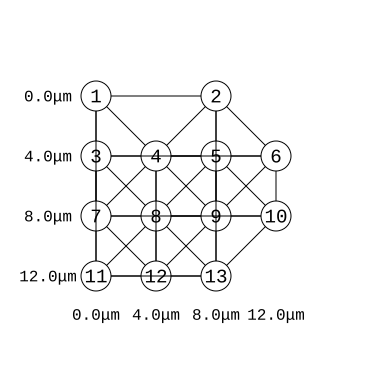

In [23]:
Rb=sqrt(sqrt(20))*a
Bloqade.plot(atoms, blockade_radius = Rb)

In [25]:
# based on methodology from Bloqade tutorial
# define a loss function that takes the weighted average number of excited atoms in a graph
# we would like to maximize this
# doesn't explicitly check for optimality or independence, but we can do this in post-processing

function loss_piecewise_linear(a, b, atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) == 3
    C6 = 2π * 862690;
    Ω_max = 4 * 2π
    Δ_start = (-13+a/2)*2π
    Δ_end = (11+b)*2π
    Δ0 = Δ_end
    T_max = 0.6

    # the strength of the detunings at each step takes the optimizing x as their input
    # we start with a piecewise linear function with some parameters, we want to fine-tune these
    Δs = smooth(
        piecewise_linear(
            clocks = T[0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
            values = T[Δ_start, Δ_start, Δ0*x[1], Δ0*x[2], Δ0*x[3], Δ_end, Δ_end],
        );
        kernel_radius = 0.02,
    )
    Ωs = smooth(
        piecewise_linear(clocks = T[0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = T[0, 0, Ω_max, Ω_max, 0, 0]);
        kernel_radius = 0.02,
    )

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, Rb)
    prob = SchrodingerProblem(zero_state(Complex{T}, subspace), T_max, hamiltonian)
    emulate!(prob)
    #return -cost_pedro(atoms, probs(prob.reg)), prob.reg, Δs
    return -rydberg_density_sum(prob.reg), prob.reg, Δs
end

x0 = [0.1, 0.8, 0.8]; # initial point for the optimization

Δ_start = -13*2π
Δ_end = 11*2π
Δ0 = Δ_end
T_max = 0.6
Δ_initial = piecewise_linear(
    clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
    values = [Δ_start, Δ_start, Δ0 * x0[1], Δ0 * x0[2], Δ0 * x0[3], Δ_end, Δ_end],
)

# outputs the initial loss
rydberg_density, reg2, Δ_initial_smooth = loss_piecewise_linear(0, 0, atoms, x0)
rydberg_density

-3.0710793975846857

In [26]:
# final optimized loss output
optresult = Optim.optimize(x -> loss_piecewise_linear(0, 0, atoms, x)[1], x0)

rydberg_density_final, reg_final, Δ_final = loss_piecewise_linear(0, 0, atoms, optresult.minimizer)
rydberg_density_final

-3.1984704331720732

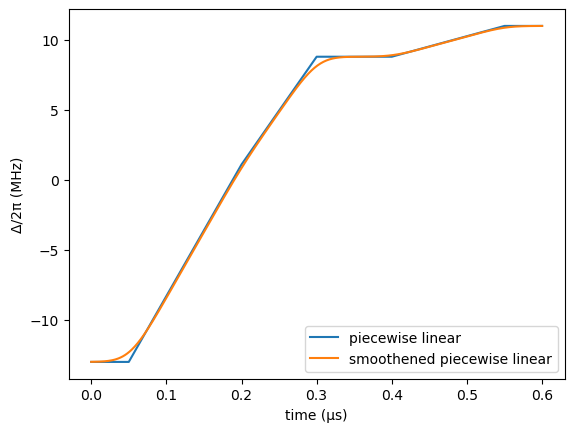

In [27]:
# how did the optimization modify the graph? blue = original, orange = final
fig, ax = plt.subplots()
Bloqade.plot!(ax, Δ_initial)
Bloqade.plot!(ax, Δ_initial_smooth)
ax.set_ylabel("Δ/2π (MHz)")
ax.legend(["piecewise linear", "smoothened piecewise linear"], loc = "lower right")
fig

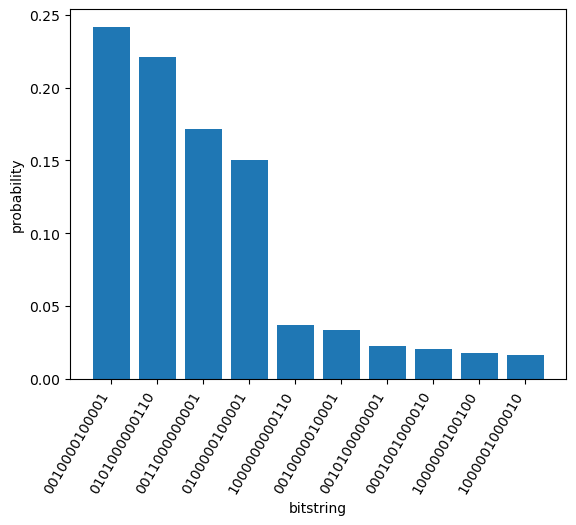

In [28]:
# first and third items valid but not optimal, second optimal
# optimal solution occurs ~20% of the time
bitstring_hist(reg_final; nlargest = 10)

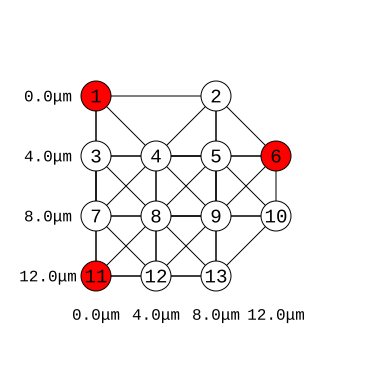

In [30]:
#valid but not optimal
best_bit_strings = most_probable(reg_final, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

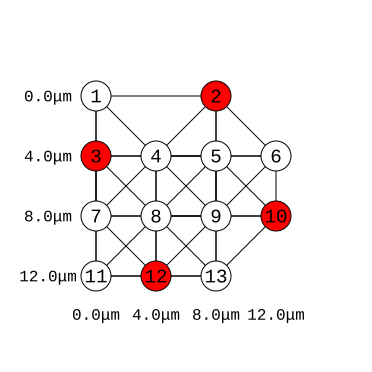

In [31]:
# optimal, occurs 20% of the time, which is pretty good for one of the hardest Rb values!
best_bit_strings = most_probable(reg_final, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

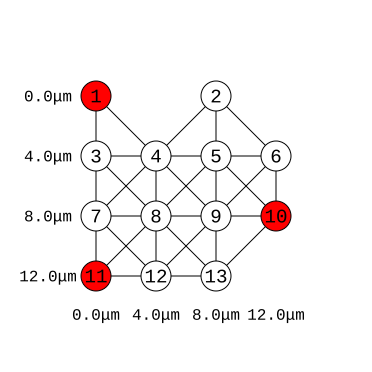

In [32]:
# valid but not optimal
best_bit_strings = most_probable(reg_final, 3)

Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[3]])

In [136]:
# old function, grid searches along non optimized function for best delta/omega values
function grid_search(min_mult, max_mult, delta, steps)
    for i in 0:steps
        #Total evolution time
        T_max = 1

        #Fix Δ according to the desired Rydberg radius
        Ω_max = min_mult*delta + (max_mult - min_mult)*delta*i/steps
        Δ_max = delta

        #Build time traces for adiabatic algorithm
        Ω = piecewise_linear(clocks = [0.0, 0.2, 0.8, T_max], values = [0.0, Ω_max, Ω_max, 0])
        Δ_start = -Δ_max
        Δ_end = Δ_max
        Δ = piecewise_linear(clocks = [0.0, 0.2, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
        
        h_kings = rydberg_h(atoms; Ω = Ω, Δ = Δ)
        prob = SchrodingerProblem(zero_state(nqubits(h_kings)), T_max, h_kings);
        emulate!(prob)
        
        println(Ω_max, " ", Δ_max, " ", rydberg_density_sum(prob.reg))
    end
end
grid_search(0, 6, C6/Rb^6, 30)

0.0 14.795501514456847 0.0
2.9591003028913696 14.795501514456847 1.9888440127588434
5.918200605782739 14.795501514456847 2.4261588846564233
8.877300908674108 14.795501514456847 2.5615482006247747
11.836401211565478 14.795501514456847 2.4245583907529777
14.795501514456847 14.795501514456847 2.368350616084703
17.754601817348217 14.795501514456847 2.2162740112501917
20.713702120239585 14.795501514456847 2.4138589907855317
23.672802423130957 14.795501514456847 2.1583620952364075
26.631902726022325 14.795501514456847 2.190414025428308
29.591003028913693 14.795501514456847 2.1491267450873206
32.55010333180506 14.795501514456847 2.4668358038542095
35.50920363469643 14.795501514456847 2.226323177386291
38.468303937587805 14.795501514456847 2.2821946941714004
41.42740424047917 14.795501514456847 2.020414593697261
44.38650454337054 14.795501514456847 2.3331274904230637
47.345604846261914 14.795501514456847 2.2721696808359897
50.30470514915328 14.795501514456847 2.228946037484733
53.2638054520446

In [ ]:
# grid search for the best delta and omega
function opt_grid_search()
    for a in -4:4
        for b in -4:4
            x0 = [0.1, 0.8, 0.8]; # initial point for the optimization

            Δ_start = (-13+a/4) * 2π
            Δ_end = (11+b/4) * 2π
            Δ0 = Δ_end
            T_max = 0.6
            Δ_initial = piecewise_linear(
                clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
                values = [Δ_start, Δ_start, Δ0 * x0[1], Δ0 * x0[2], Δ0 * x0[3], Δ_end, Δ_end],
            )
            optresult = Optim.optimize(x -> loss_piecewise_linear(a, b, atoms, x)[1], x0)

            rydberg_density_final, reg_final, Δ_final = loss_piecewise_linear(a, b, atoms, optresult.minimizer)
            println(optresult.minimizer)
            println(Δ_start, " ", Δ_end, " ", rydberg_density_final)
        end
    end
end

opt_grid_search()

[0.24341433235117596, 0.622321493126969, 1.1831245389205918]
-87.96459430051421 62.83185307179586 -3.1243942720876294
[0.21850021553866528, 0.590141701339195, 0.949656351319748]
-87.96459430051421 64.40264939859075 -3.1868362868931954
[0.21045349025629895, 0.5611163296750671, 0.7853934787501148]
-87.96459430051421 65.97344572538566 -3.2377304798770106
[0.14025099185972253, 0.5950170169735297, 1.3519770951686958]
-87.96459430051421 67.54424205218055 -3.193617536980704
[0.19530140925448675, 0.49660372863452823, 0.5905873664469281]
-87.96459430051421 69.11503837897544 -3.297735246427469
[0.1864573912932655, 0.4655481205845056, 0.5315472572723667]
-87.96459430051421 70.68583470577035 -3.3100875442482587
[0.17699908280421117, 0.43676434791255764, 0.48689758174088765]
-87.96459430051421 72.25663103256524 -3.314946927975257
[0.16722056045901193, 0.4104820415200814, 0.4523074619111448]
-87.96459430051421 73.82742735936014 -3.3153586879709365
[0.15756522997391045, 0.38661414577518266, 0.4245825

In [120]:
# Cost functions
# the cost function that we used did not check for optimality or independence
# we implemented a cost function that does check for these, but gradient descent did not converge well for this
# likely because the function is less continuous or too strict
function is_IS(atoms, str)
    n_atoms = length(atoms)
    for i in 1:n_atoms
        # print("Checking: ")
        # println(i)
        if str[n_atoms-i+1] == '1'
            for j in 1:n_atoms
                # println(j)
                # println(str[j])
                if (sqrt((atoms[i][1] - atoms[j][1])^2 + (atoms[i][2] - atoms[j][2])^2) <= Rb) && (str[n_atoms-j+1] == '1') && (i != j)
                    return false
                end
            end
        end
    end
    return true
end

function int_to_bitstring(num, n_bits)
    str = ""
    while num > 0
        str = string(num % 2, str)
        num = num ÷ 2
    end
    while length(str) < n_bits
        str = string('0', str)
    end
    return str
end

function count_in_string(haystack, needle)
    count = 0
    for c in haystack
        if c == needle
            count += 1
        end
    end
    return count
end

function cost_R(atoms, probabilities)
    n_strings = length(probabilities)
    string_size = length(atoms)
    sum = 0
    n_mis = 0
    mis_size = 0
    for i in 1:n_strings
        str = int_to_bitstring(i-1, string_size)
        if is_IS(atoms, str)
            n_ones = count_in_string(str, '1')
            sum += n_ones
            n_mis += 1
            mis_size = max(mis_size, n_ones)
        end
    end
    return (sum / n_mis) / mis_size
end

function get_mis_size(atoms, probabilities)
    n_strings = length(probabilities)
    string_size = length(atoms)
    max_mis_size = 0
    for i in 1:n_strings
        str = int_to_bitstring(i-1, string_size)
        if is_IS(atoms, str)
            max_mis_size = max(max_mis_size, count_in_string(str, '1'))
        end
    end
    return max_mis_size
end

function cost_pedro(atoms, probabilities)
    n_strings = length(probabilities)
    string_size = length(atoms)
    mis_size = get_mis_size(atoms, probabilities)
    cost = 0
    for i in 1:n_strings
        str = int_to_bitstring(i-1, string_size)
        if is_IS(atoms, str) && count_in_string(str, '1') == mis_size
            cost += probabilities[i]
        end
    end
    return cost
end

cost_pedro (generic function with 1 method)